In [22]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os


In [23]:
# Importing Libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt

In [24]:
# creating models directory
import os
if not os.path.isdir('models'):
    os.mkdir('models')
# checking TensorFlow version and GPU usage
print('Tensorflow version:', tf.__version__)
print('Is using GPU?', tf.test.is_gpu_available())

Tensorflow version: 2.4.1
Is using GPU? True


In [25]:
!nvidia-smi

Wed Jul 21 18:24:42 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.119.04   Driver Version: 450.119.04   CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   59C    P0    37W / 250W |  15595MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Data set information

In [26]:
#Extra Part for Data understanding train data
SIZE = 224
WORKERS = 2
CHANNEL = 3
NUM_CLASSES = 10

TRAIN_PATH ="/kaggle/input/plantvillage-tomato-leaf-dataset/plantvillage"

TRAIN_FOLDERS = np.sort(os.listdir(TRAIN_PATH))

# Working on 10 class (all )
TRAIN_FOLDERS = np.array(pd.DataFrame(TRAIN_FOLDERS).sample(10)).reshape(-1)

In [27]:
train_labels = []

def generate_train_labels():
    for fruit_name in TRAIN_FOLDERS:
        images = os.listdir( '/kaggle/input/plantvillage-tomato-leaf-dataset/plantvillage/'+fruit_name)
        for image in range(len(images)):
            train_labels.append(fruit_name)
            
            
generate_train_labels()


train_labels = pd.get_dummies(train_labels)

labels = train_labels


train_labels = np.float32(train_labels[list(TRAIN_FOLDERS)].values)

train_labels[:10]

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [28]:
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff

In [29]:
fig = go.Figure(
                [go.Pie(labels=TRAIN_FOLDERS, 
                        values=labels.sum().values,
                        marker=dict(colors=['#026416','#C73104','#C05209','#6F2F05']))
                ])

fig.update_layout(width=900, height=400, title= {'text': "Tomato Leafe Disease Categories Distribution for Train Data",
                                                'y':0.95,'x':0.43,
                                                'xanchor': 'center','yanchor': 'top'},
                 margin = dict(l=50, r=10, t=50, b=30))

In [30]:
import time
from keras.preprocessing.image import ImageDataGenerator


In [31]:
image_generator = ImageDataGenerator(shear_range=0.2,
                                     zoom_range=0.2,
                                     horizontal_flip=True,
                                     validation_split=0.15) # set validation split

In [32]:
%time
train_dataset = image_generator.flow_from_directory(batch_size=32,
                                                 directory='/kaggle/input/plantvillage-tomato-leaf-dataset/plantvillage/plantvillage',
                                                 shuffle=True,
                                                 target_size=(224, 224), 
                                                 subset="training",
                                                 class_mode='categorical')

validation_dataset = image_generator.flow_from_directory(batch_size=32,
                                                 directory='/kaggle/input/plantvillage-tomato-leaf-dataset/plantvillage/plantvillage',
                                                 shuffle=False,
                                                 target_size=(224, 224), 
                                                 subset="validation",
                                                 class_mode='categorical')

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 10.3 µs
Found 12354 images belonging to 10 classes.
Found 2175 images belonging to 10 classes.


In [33]:
train_dataset.image_shape

(224, 224, 3)

In [34]:
validation_dataset.image_shape

(224, 224, 3)

# Custom model creation

In [35]:
from tensorflow.keras.applications import Xception

In [36]:
n_layers = 30
img_shape = (224, 224, 3)

Creating the Model¶ For this model I'm going to use the Xception architecture and load weights pre-trained on ImageNet. I set include_top to be false so that I am not using the fully-connected layer at the top of the network. Next I set the first 30 layers to be not trainable. That way I keep the pretrained weights for those layers. Next, I add a pooling and dense layer, followed by a dropout layer. The last 50 layer is a dense layer with 10 neurons since there are 10 classes.

In [37]:
base_model  = Xception(input_shape=img_shape, include_top=False, weights='imagenet')
head_model = base_model
for layers in base_model.layers[:n_layers]:
    layers.trainable = False

In [38]:
head_model = head_model.output
head_model = tf.keras.layers.GlobalMaxPooling2D()(head_model)


head_model = tf.keras.layers.Flatten(name="Flatten")(head_model)
head_model = tf.keras.layers.Dense(512, activation='relu')(head_model)
head_model = tf.keras.layers.Dropout(0.5)(head_model)



prediction_layer = tf.keras.layers.Dense(10, activation='softmax')(head_model)


model = tf.keras.Model(inputs=base_model.input, outputs=prediction_layer)

In [39]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 111, 111, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 111, 111, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 111, 111, 32) 0           block1_conv1_bn[0][0]            
____________________________________________________________________________________________

In [40]:
from tensorflow.keras.optimizers import Adam
model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(lr=0.001),
    metrics=['accuracy'])

In [43]:
# Train the Model
history = model.fit(train_dataset,

          epochs=5,
          validation_data=validation_dataset,
          callbacks=[
          # Stopping our training if val_accuracy doesn't improve after 8 epochs
          tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', 
                                           patience=5),
          # Saving the best weights of our model in the model directory
        
          # We don't want to save just the weight, but also the model architecture
          tf.keras.callbacks.ModelCheckpoint('models/model_{val_accuracy:.3f}.h5',
                                           save_best_only=True,
                                           save_weights_only=False,
                                           monitor='val_accuracy'
                                             )
    ])

Epoch 1/5
387/387 [==============================] - 196s 506ms/step - loss: 0.1594 - accuracy: 0.9499 - val_loss: 0.6661 - val_accuracy: 0.8782
Epoch 2/5
387/387 [==============================] - 197s 509ms/step - loss: 0.1905 - accuracy: 0.9441 - val_loss: 1.0652 - val_accuracy: 0.7669
Epoch 3/5
387/387 [==============================] - 196s 506ms/step - loss: 0.1282 - accuracy: 0.9624 - val_loss: 0.2725 - val_accuracy: 0.9154
Epoch 4/5
387/387 [==============================] - 197s 510ms/step - loss: 0.1158 - accuracy: 0.9654 - val_loss: 0.1276 - val_accuracy: 0.9563
Epoch 5/5
387/387 [==============================] - 197s 508ms/step - loss: 0.1448 - accuracy: 0.9552 - val_loss: 0.1510 - val_accuracy: 0.9517


Text(0.5, 0, 'epoch')

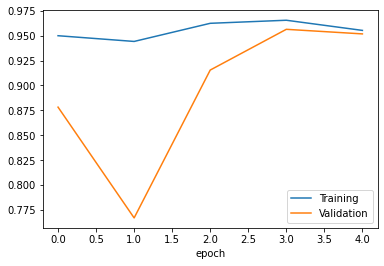

In [44]:
# Plot graph between training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['Training', 'Validation'])
plt.xlabel('epoch')

In [45]:
# Performance Evaluation
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [46]:
# loading the best perfoming model
model = tf.keras.models.load_model('./models/model_0.956.h5')


In [49]:
# Generate generalization metrics
score = model.evaluate(validation_dataset, verbose=0)
print(f'Test loss: {score[0]} / Model Validation accuracy: {score[1]}')

Test loss: 0.12478451430797577 / Model Validation accuracy: 0.9577011466026306


# Prediction on Test Data/Unseen Data 

In [50]:
#Print the Target names

target_names = []

for key in train_dataset.class_indices:

    target_names.append(key)



print(target_names)

['Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Spot', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato___Tomato_mosaic_virus', 'Tomato___healthy']


In [51]:
from sklearn.metrics import classification_report, confusion_matrix

In [52]:
#Plot the confusion matrix. Set Normalize = True/False



def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):

    """

    This function prints and plots the confusion matrix.

    Normalization can be applied by setting `normalize=True`.

    """

    plt.figure(figsize=(10,10))



    plt.imshow(cm, interpolation='nearest', cmap=cmap)

    plt.title(title)

    plt.colorbar()



    tick_marks = np.arange(len(classes))

    plt.xticks(tick_marks, classes, rotation=45)

    plt.yticks(tick_marks, classes)



    if normalize:

        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

        cm = np.around(cm, decimals=2)

        cm[np.isnan(cm)] = 0.0

        print("Normalized confusion matrix")

    else:

        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):

        plt.text(j, i, cm[i, j],

                 horizontalalignment="center",

                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()

    plt.ylabel('True label')

    plt.xlabel('Predicted label')

In [53]:
import matplotlib.pyplot as plt

from keras.optimizers import Adam

import itertools

In [54]:
image_generator = ImageDataGenerator(shear_range=0.2,
                                     zoom_range=0.4,
                                     horizontal_flip=True)

In [55]:
final_dataset = image_generator.flow_from_directory(batch_size=32,
                                                 directory='../input/unseen-data-for-testing/test data',
                                                 shuffle=False,
                                                 target_size=(224, 224), 
                                                 class_mode='categorical')

Found 4585 images belonging to 10 classes.


Confusion Matrix
Normalized confusion matrix


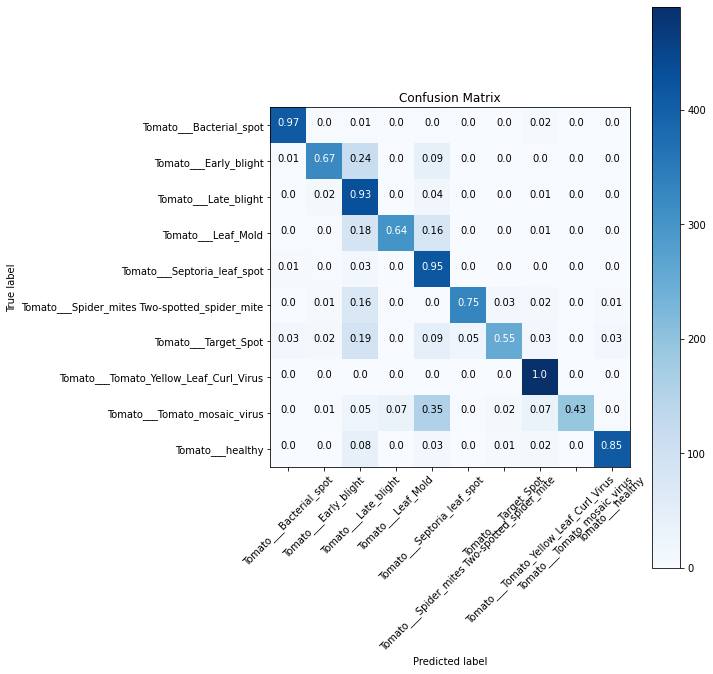

In [60]:
#Confution Matrix 

Y_pred = model.predict_generator(final_dataset)

y_pred = np.argmax(Y_pred, axis=1)

print('Confusion Matrix')

cm = confusion_matrix(final_dataset.classes, y_pred)

plot_confusion_matrix(cm, target_names, title='Confusion Matrix')

In [61]:

#Print Classification Report

print('Classification Report')

print(classification_report(final_dataset.classes, y_pred, target_names=target_names))

Classification Report
                                               precision    recall  f1-score   support

                      Tomato___Bacterial_spot       0.94      0.97      0.96       425
                        Tomato___Early_blight       0.90      0.67      0.76       480
                         Tomato___Late_blight       0.50      0.93      0.65       463
                           Tomato___Leaf_Mold       0.90      0.64      0.75       470
                  Tomato___Septoria_leaf_spot       0.54      0.95      0.69       436
Tomato___Spider_mites Two-spotted_spider_mite       0.93      0.75      0.83       435
                         Tomato___Target_Spot       0.90      0.55      0.68       457
       Tomato___Tomato_Yellow_Leaf_Curl_Virus       0.86      1.00      0.93       490
                 Tomato___Tomato_mosaic_virus       1.00      0.43      0.60       448
                             Tomato___healthy       0.95      0.85      0.90       481

                   